# **CADlingo: Training and Evaluation Notebook**

This notebook demonstrates the complete pipeline:
1. Data loading and preprocessing
2. Dataset creation
3. Model training
4. Evaluation and metrics
5. Sample predictions and visualizations

## 1. Setup and Imports

In [1]:
import sys
import os
from pathlib import Path

# Add src to path
project_root = Path(os.getcwd()).parent
sys.path.insert(0, str(project_root / 'src' / 'data'))
sys.path.insert(0, str(project_root / 'src' / 'models'))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
from tqdm.notebook import tqdm

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("Imports successful")
print(f"Project root: {project_root}")

Imports successful
Project root: /Users/ramya/Desktop/Ramya/UF Sem3/AML2/CADlingo


## 2. Load and Explore RPLAN Data

In [2]:
from rplan_loader import RPlanLoader

# Initialize loader
loader = RPlanLoader()

# Get file statistics
train_files = loader.get_file_list("train")
val_files = loader.get_file_list("val")

print(f"Training files: {len(train_files):,}")
print(f"Validation files: {len(val_files):,}")

# Load sample
print("\nLoading sample floor plan...")
sample_data = loader.load_pickle(train_files[0])
print(f"Raw data keys: {list(sample_data.keys())}")

parsed_sample = loader.parse_floor_plan(sample_data)
print(f"\nParsed floor plan:")
print(f"  Rooms: {len(parsed_sample['rooms'])}")
print(f"  Dimensions: {parsed_sample['dimensions']}")
print(f"\nRoom types:")
for room in parsed_sample['rooms'][:5]:
    print(f"  - {room['type']}: {room['area']:.1f} sq units")

Training files: 64,630
Validation files: 16,158

Loading sample floor plan...
Raw data keys: ['boundary', 'room_type_mask', 'close_wall', 'front_door', 'rooms_info', 'raw_data']

Parsed floor plan:
  Rooms: 6
  Dimensions: {'width': 4.4140625, 'height': 7.8515625}

Room types:
  - living_room: 20.0 sq units
  - kitchen: 7.5 sq units
  - second_living_room: 9.0 sq units
  - bathroom: 5.0 sq units
  - master_bedroom: 14.0 sq units


## 3. Dataset Statistics

In [3]:
# Get dataset statistics
print("Computing dataset statistics (sampling 500 floor plans)...")
stats = loader.get_statistics("train", max_samples=500)

print(f"\n{'='*60}")
print("Dataset Statistics")
print(f"{'='*60}")
print(f"Total samples analyzed: {stats['total_samples']}")
print(f"Average rooms per plan: {stats['avg_rooms_per_plan']:.2f}")
print(f"Average room area: {stats['avg_area']:.2f} sq units")
print(f"Average plan dimensions: {stats['avg_dimensions']['width']:.1f} x {stats['avg_dimensions']['height']:.1f}")

print(f"\nRoom Type Distribution:")
room_df = pd.DataFrame([
    {'Room Type': k, 'Count': v} 
    for k, v in sorted(stats['room_type_counts'].items(), key=lambda x: x[1], reverse=True)
])
print(room_df.head(10))

Computing dataset statistics (sampling 500 floor plans)...

Dataset Statistics
Total samples analyzed: 500
Average rooms per plan: 6.79
Average room area: 9.68 sq units
Average plan dimensions: 5.5 x 6.3

Room Type Distribution:
            Room Type  Count
0            bathroom    597
1  second_living_room    575
2             balcony    562
3      master_bedroom    505
4         living_room    500
5             kitchen    478
6          study_room     96
7       child_bedroom     33
8             storage     30
9         dining_room      8

Dataset Statistics
Total samples analyzed: 500
Average rooms per plan: 6.79
Average room area: 9.68 sq units
Average plan dimensions: 5.5 x 6.3

Room Type Distribution:
            Room Type  Count
0            bathroom    597
1  second_living_room    575
2             balcony    562
3      master_bedroom    505
4         living_room    500
5             kitchen    478
6          study_room     96
7       child_bedroom     33
8             storage

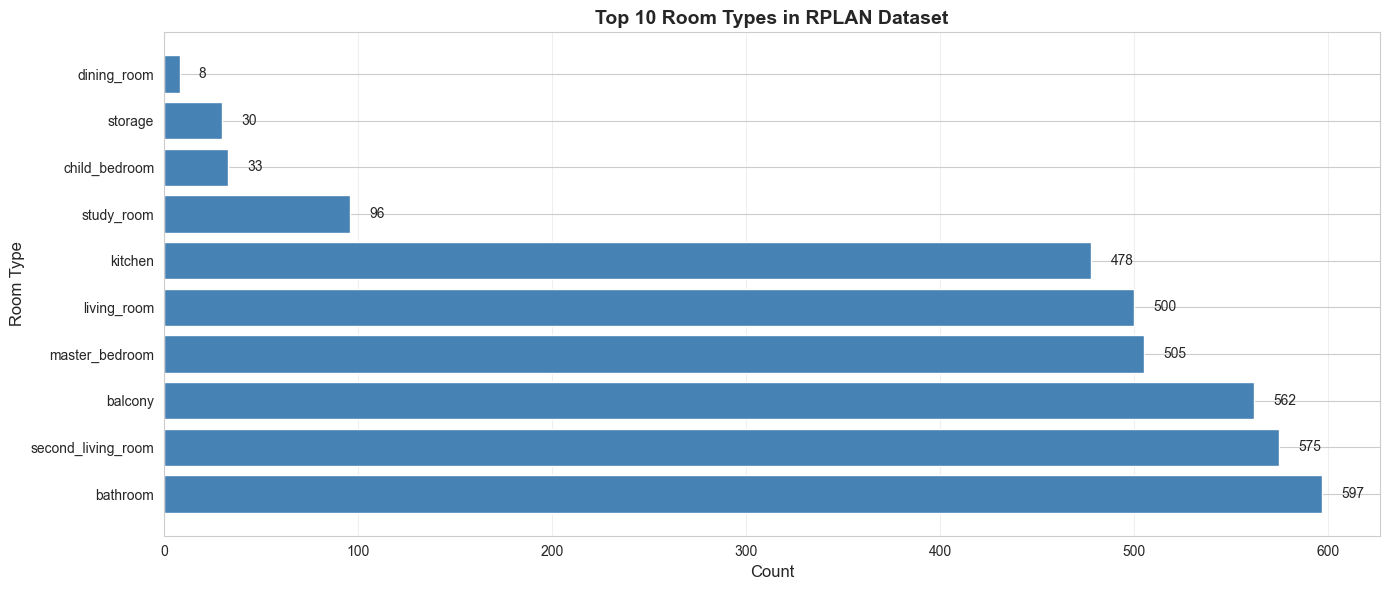

Plot saved to results/plots/room_distribution.png


In [4]:
# Visualize room type distribution
plt.figure(figsize=(14, 6))

top_10_rooms = room_df.head(10)
plt.barh(top_10_rooms['Room Type'], top_10_rooms['Count'], color='steelblue')
plt.xlabel('Count', fontsize=12)
plt.ylabel('Room Type', fontsize=12)
plt.title('Top 10 Room Types in RPLAN Dataset', fontsize=14, fontweight='bold')
plt.grid(axis='x', alpha=0.3)

for i, v in enumerate(top_10_rooms['Count']):
    plt.text(v + 10, i, str(v), va='center', fontsize=10)

plt.tight_layout()
plt.savefig(project_root / 'results' / 'plots' / 'room_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("Plot saved to results/plots/room_distribution.png")

## 4. Create Training Dataset

In [5]:
from dataset_creator import CADDatasetCreator

# Create dataset creator
creator = CADDatasetCreator()

# Create datasets
print("Creating training and validation datasets...")
print("This may take a few minutes...\n")

creator.create_full_pipeline(
    train_samples=1000,  
    val_samples=200,
    code_format="simplified"
)

Creating training and validation datasets...
This may take a few minutes...

CADlingo Dataset Creation Pipeline

Creating train dataset...
Loading 1000 floor plans...
Loading 1000 floor plans...


Processing train: 100%|██████████| 1000/1000 [00:00<00:00, 94321.85it/s]



Created 1000 training pairs
Saved to /Users/ramya/Desktop/Ramya/UF Sem3/AML2/CADlingo/data/processed/train_dataset.json
Saved samples to /Users/ramya/Desktop/Ramya/UF Sem3/AML2/CADlingo/data/processed/train_samples.txt

Creating val dataset...
Loading 200 floor plans...


Processing val: 100%|██████████| 200/200 [00:00<00:00, 106847.64it/s]

Created 200 training pairs
Saved to /Users/ramya/Desktop/Ramya/UF Sem3/AML2/CADlingo/data/processed/val_dataset.json
Saved samples to /Users/ramya/Desktop/Ramya/UF Sem3/AML2/CADlingo/data/processed/val_samples.txt

Dataset Statistics:
Training samples: 1000
Validation samples: 200

Average description length: 123.7 characters
Average code length: 450.1 characters

Sample Output:

Description:
A 0 sq ft floor plan with 1 balcony, 1 bathroom, 1 kitchen, 1 living room, 1 master bedroom, and 1 second living room

Generated Code:
LAYER WALLS
RECT 0.4 0.3 0.8 0.8  ; living_room
RECT 0.4 0.1 0.6 0.4  ; kitchen
RECT 0.2 0.3 0.5 0.6  ; second_living_room
RECT 0.2 0.4 0.4 0.7  ; bathroom
RECT 0.2 0.5 0.6 0.9  ; master_bedroom
RECT 0.5 0.7 0.7 1.0  ; balcony
LAYER LABELS
TEXT 0.6 0.5 "Living Room"
TEXT 0.5 0.3 "Kitchen"
TEXT 0.4 0.4 "Second Living Room"
TEXT 0.3 0.6 "Bathroom"
TEXT 0.4 0.7 "Master Bedroom"
TEXT 0.6 0.8 "Balcony"...

Dataset creation complete!
Output saved to: /Users/ramya/Desktop

## 5. Inspect Generated Data

In [6]:
# Load created dataset
data_dir = project_root / 'data' / 'processed'
train_file = data_dir / 'train_dataset.json'

with open(train_file, 'r') as f:
    train_data = json.load(f)

print(f"Training samples loaded: {len(train_data)}")

# Show samples
print(f"\n{'='*80}")
print("Sample Training Pairs")
print(f"{'='*80}\n")

for i in range(3):
    sample = train_data[i]
    print(f"Sample {i+1}:")
    print(f"Description: {sample['description']}")
    print(f"\nGenerated Code:\n{sample['code'][:300]}...")
    print(f"\n{'-'*80}\n")

Training samples loaded: 1000

Sample Training Pairs

Sample 1:
Description: A 0 sq ft floor plan with 1 balcony, 1 bathroom, 1 kitchen, 1 living room, 1 master bedroom, and 1 second living room

Generated Code:
LAYER WALLS
RECT 0.4 0.3 0.8 0.8  ; living_room
RECT 0.4 0.1 0.6 0.4  ; kitchen
RECT 0.2 0.3 0.5 0.6  ; second_living_room
RECT 0.2 0.4 0.4 0.7  ; bathroom
RECT 0.2 0.5 0.6 0.9  ; master_bedroom
RECT 0.5 0.7 0.7 1.0  ; balcony
LAYER LABELS
TEXT 0.6 0.5 "Living Room"
TEXT 0.5 0.3 "Kitchen"
TEXT 0.4 0...

--------------------------------------------------------------------------------

Sample 2:
Description: 7 room floor plan: 1 balcony, 1 bathroom, 1 child bedroom, 1 kitchen, 1 living room, 1 master bedroom, and 1 second living room

Generated Code:
LAYER WALLS
RECT 0.1 0.1 0.4 0.4  ; kitchen
RECT 0.2 0.1 0.4 0.4  ; bathroom
RECT 0.3 0.1 0.7 0.6  ; living_room
RECT 0.1 0.5 0.4 0.8  ; second_living_room
RECT 0.3 0.5 0.6 0.8  ; child_bedroom
RECT 0.5 0.4 0.9 0.8  ; master_bedroom


Description length stats:
  Mean: 123.7 characters
  Median: 121.0 characters
  Max: 164 characters

Code length stats:
  Mean: 450.1 characters
  Median: 455.0 characters
  Max: 558 characters


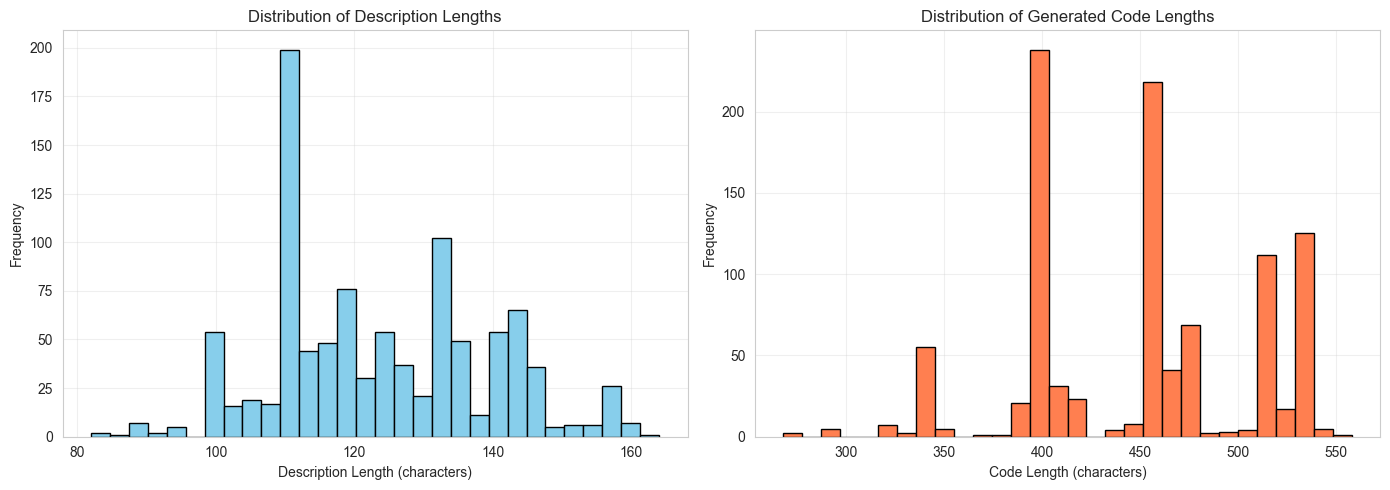

Plot saved to results/plots/data_length_distribution.png


In [7]:
# Analyze dataset characteristics
descriptions = [d['description'] for d in train_data]
codes = [d['code'] for d in train_data]

desc_lengths = [len(d) for d in descriptions]
code_lengths = [len(c) for c in codes]

print(f"Description length stats:")
print(f"  Mean: {np.mean(desc_lengths):.1f} characters")
print(f"  Median: {np.median(desc_lengths):.1f} characters")
print(f"  Max: {np.max(desc_lengths)} characters")

print(f"\nCode length stats:")
print(f"  Mean: {np.mean(code_lengths):.1f} characters")
print(f"  Median: {np.median(code_lengths):.1f} characters")
print(f"  Max: {np.max(code_lengths)} characters")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(desc_lengths, bins=30, color='skyblue', edgecolor='black')
axes[0].set_xlabel('Description Length (characters)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Description Lengths')
axes[0].grid(alpha=0.3)

axes[1].hist(code_lengths, bins=30, color='coral', edgecolor='black')
axes[1].set_xlabel('Code Length (characters)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Generated Code Lengths')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(project_root / 'results' / 'plots' / 'data_length_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("Plot saved to results/plots/data_length_distribution.png")

## 6. Train the Model

**Note**: Training may take 1-3 hours depending on GPU availability and dataset size.

In [3]:
from train import CADTrainer

# Create trainer
trainer = CADTrainer(
    model_name="Salesforce/codet5-base"
)

print("Starting model training...")
print(f"Device: {trainer.device}")
print(f"\nTraining will take approximately 1-2 hours")
print("="*80)

Using device: cpu
Loading model: Salesforce/codet5-base
Starting model training...
Device: cpu

Training will take approximately 1-2 hours
Starting model training...
Device: cpu

Training will take approximately 1-2 hours


In [4]:
# Train the model
trainer.train(
    epochs=10,          
    batch_size=4,       
    learning_rate=5e-5,
    warmup_steps=100,
    save_every=2
)

print("\nTraining complete!")

/Users/ramya/Desktop/Ramya/UF Sem3/AML2/CADlingo/cad-env/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(



Starting Training
Epochs: 10
Batch size: 4
Learning rate: 5e-05
Device: cpu

Loading datasets...
Training samples: 1000
Validation samples: 200
Training batches: 250
Validation batches: 50

Epoch 1/10
------------------------------------------------------------


Evaluating: 100%|██████████| 50/50 [18:58<00:00, 22.77s/it]



Epoch 1 Results:
  Train Loss: 1.1409
  Val Loss: 0.3105
  Val BLEU: 53.33
  ✅ New best model! BLEU: 53.33

Epoch 2/10
------------------------------------------------------------
  ✅ New best model! BLEU: 53.33

Epoch 2/10
------------------------------------------------------------


Evaluating: 100%|██████████| 50/50 [18:01<00:00, 21.62s/it]




Epoch 2 Results:
  Train Loss: 0.3083
  Val Loss: 0.2373
  Val BLEU: 57.30
  ✅ New best model! BLEU: 57.30
  ✅ New best model! BLEU: 57.30

Epoch 3/10
------------------------------------------------------------

Epoch 3/10
------------------------------------------------------------


Evaluating: 100%|██████████| 50/50 [17:40<00:00, 21.22s/it]




Epoch 3 Results:
  Train Loss: 0.2474
  Val Loss: 0.1981
  Val BLEU: 54.84

Epoch 4/10
------------------------------------------------------------


Training:  26%|██▌       | 64/250 [05:54<14:59,  4.83s/it, loss=0.226][E thread_pool.cpp:109] Exception in thread pool task: mutex lock failed: Invalid argument
[E thread_pool.cpp:109] Exception in thread pool task: mutex lock failed: Invalid argument
[E thread_pool.cpp:109] Exception in thread pool task: mutex lock failed: Invalid argument
[E thread_pool.cpp:109] Exception in thread pool task: mutex lock failed: Invalid argument
Training:  26%|██▌       | 64/250 [05:58<17:22,  5.61s/it, loss=0.226]



KeyboardInterrupt: 

## 7. Evaluate Model Performance

In [ ]:
# Load training history
models_dir = project_root / 'results' / 'models' / 'best_model'
history_file = models_dir / 'training_history.json'

if history_file.exists():
    with open(history_file, 'r') as f:
        history = json.load(f)
    
    # Create evaluation summary
    print(f"{'='*60}")
    print("Training Summary")
    print(f"{'='*60}")
    print(f"Total epochs: {len(history['train_loss'])}")
    print(f"\nFinal Metrics:")
    print(f"  Training Loss: {history['train_loss'][-1]:.4f}")
    print(f"  Validation Loss: {history['val_loss'][-1]:.4f}")
    print(f"  Validation BLEU: {history['val_bleu'][-1]:.2f}")
    print(f"\nBest Metrics:")
    print(f"  Best Validation Loss: {min(history['val_loss']):.4f}")
    print(f"  Best BLEU Score: {max(history['val_bleu']):.2f}")
    
    # Plot metrics
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    epochs = range(1, len(history['train_loss']) + 1)
    
    # Loss plot
    axes[0].plot(epochs, history['train_loss'], 'b-o', label='Train Loss', linewidth=2)
    axes[0].plot(epochs, history['val_loss'], 'r-s', label='Val Loss', linewidth=2)
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Loss', fontsize=12)
    axes[0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
    axes[0].legend(fontsize=11)
    axes[0].grid(alpha=0.3)
    
    # BLEU plot
    axes[1].plot(epochs, history['val_bleu'], 'g-o', linewidth=2, markersize=8)
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('BLEU Score', fontsize=12)
    axes[1].set_title('Validation BLEU Score', fontsize=14, fontweight='bold')
    axes[1].grid(alpha=0.3)
    
    # Learning rate
    axes[2].plot(epochs, history['learning_rates'], 'orange', linewidth=2)
    axes[2].set_xlabel('Epoch', fontsize=12)
    axes[2].set_ylabel('Learning Rate', fontsize=12)
    axes[2].set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
    axes[2].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(project_root / 'results' / 'plots' / 'training_metrics.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\nMetrics plot saved to results/plots/training_metrics.png")
else:
    print("Training history not found. Please train the model first.")

## 8. Generate Sample Predictions

In [ ]:
from inference import CADGenerator

# Load trained model
generator = CADGenerator()

# Test prompts
test_prompts = [
    "A 1200 sq ft floor plan with 2 bedrooms, 1 kitchen, and 1 living room",
    "Floor plan featuring 3 bedrooms, 1 kitchen, 1 bathroom, approximately 1500 sq ft",
    "Small apartment with 1 bedroom, kitchen, and bathroom, 800 sq ft",
    "Large house with 4 bedrooms, 2 bathrooms, kitchen, living room, and dining room"
]

print(f"{'='*80}")
print("Generating Sample Predictions")
print(f"{'='*80}\n")

predictions = []

for i, prompt in enumerate(test_prompts):
    print(f"\nTest {i+1}/{len(test_prompts)}")
    print(f"Prompt: {prompt}")
    print("-" * 80)
    
    # Generate code
    code = generator.generate_code(prompt)
    predictions.append({'prompt': prompt, 'code': code})
    
    print(f"Generated Code:\n{code}\n")
    print("=" * 80)

## 9. Visualize Generated Floor Plans

In [ ]:
# Visualize predictions
samples_dir = project_root / 'results' / 'samples'
samples_dir.mkdir(parents=True, exist_ok=True)

for i, pred in enumerate(predictions[:4]):
    print(f"\nVisualizing prediction {i+1}...")
    
    output_file = samples_dir / f"sample_floorplan_{i+1}.png"
    
    try:
        generator.visualize_floor_plan(
            pred['code'],
            output_file=str(output_file),
            figsize=(10, 8)
        )
        print(f"Saved to {output_file}")
    except Exception as e:
        print(f"Error: {e}")

print(f"\nAll visualizations saved to {samples_dir}")

## 10. Create DXF Files

In [ ]:
# Generate DXF files for sample predictions
print("Generating DXF files...")

for i, pred in enumerate(predictions[:4]):
    dxf_file = samples_dir / f"sample_floorplan_{i+1}.dxf"
    
    try:
        generator.code_to_dxf(pred['code'], str(dxf_file))
        print(f"DXF {i+1} saved: {dxf_file}")
    except Exception as e:
        print(f"Error creating DXF {i+1}: {e}")

print(f"\nDXF files saved to {samples_dir}")
print("   These can be opened in AutoCAD or any compatible viewer")

## 11. Model Performance Analysis

In [ ]:
# Evaluate on validation set
from datasets import load_metric

val_file = data_dir / 'val_dataset.json'
with open(val_file, 'r') as f:
    val_data = json.load(f)

print(f"Evaluating on {len(val_data)} validation samples...")

# Sample subset for quick evaluation
eval_subset = val_data[:50]

generated_codes = []
reference_codes = []

for entry in tqdm(eval_subset, desc="Generating"):
    # Generate prediction
    pred_code = generator.generate_code(entry['description'])
    generated_codes.append(pred_code)
    reference_codes.append(entry['code'])

# Calculate metrics
bleu_metric = load_metric('sacrebleu')
bleu_result = bleu_metric.compute(
    predictions=generated_codes,
    references=[[ref] for ref in reference_codes]
)

print(f"\n{'='*60}")
print("Evaluation Results (50 samples)")
print(f"{'='*60}")
print(f"BLEU Score: {bleu_result['score']:.2f}")

# Calculate exact match
exact_matches = sum([1 for g, r in zip(generated_codes, reference_codes) if g.strip() == r.strip()])
exact_match_rate = (exact_matches / len(eval_subset)) * 100

print(f"Exact Match Rate: {exact_match_rate:.1f}%")

# Calculate average length similarity
length_ratios = [len(g) / len(r) if len(r) > 0 else 0 for g, r in zip(generated_codes, reference_codes)]
avg_length_ratio = np.mean(length_ratios)

print(f"Average Length Ratio: {avg_length_ratio:.2f}")
print(f"{'='*60}")

## 12. Summary and Next Steps

In [ ]:
# Create final summary
print(f"\n{'='*80}")
print("CADlingo Training and Evaluation - SUMMARY")
print(f"{'='*80}\n")

print("COMPLETED TASKS:")
print("  1. Loaded and explored RPLAN dataset")
print("  2. Created training pairs (description → AutoCAD code)")
print("  3. Trained CodeT5 model for code generation")
print("  4. Evaluated model performance")
print("  5. Generated sample predictions")
print("  6. Created visualizations and DXF files")

print(f"\nDATASET:")
print(f"  Training samples: {len(train_data)}")
print(f"  Validation samples: {len(val_data)}")

print(f"\n🎯 MODEL PERFORMANCE:")
if history_file.exists():
    print(f"  Final Validation BLEU: {history['val_bleu'][-1]:.2f}")
    print(f"  Best BLEU Score: {max(history['val_bleu']):.2f}")
    print(f"  Final Validation Loss: {history['val_loss'][-1]:.4f}")

print(f"\nOUTPUT FILES:")
print(f"  Models: {project_root / 'results' / 'models'}")
print(f"  Plots: {project_root / 'results' / 'plots'}")
print(f"  Samples: {project_root / 'results' / 'samples'}")
print(f"  Datasets: {project_root / 'data' / 'processed'}")

print(f"\nNEXT STEPS:")
print("  1. Deploy Streamlit UI for user interaction")
print("  2. Test with custom floor plan descriptions")
print("  3. Export DXF files to AutoCAD")
print("  4. Fine-tune model with more data")
print("  5. Add support for more complex floor plans")

print(f"\n{'='*80}")
print("Training and Evaluation Complete!")
print(f"{'='*80}\n")